<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="BS"></a><h1 style="text-align:center;">Hawkes process simulation</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [30]:
%load_ext autoreload
%autoreload 2
import sys
if "../" not in sys.path:
    sys.path.append("../")

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
from scipy.special import gamma
from scipy.stats import ks_2samp, kstest
from dataclasses import dataclass

from volterra_hawkes.iVi.iVi_hawkes import IVIHawkesProcess
from volterra_hawkes.kernel.kernels import *
from volterra_hawkes.point_processes.hawkes import simulate_hawkes, simulate_hawkes_ogata, U_from_jumps, lam_from_jumps, N_from_jumps

color_cycle = ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"]
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=color_cycle)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualisation of the trajectories

In [49]:
@dataclass
class Experiment:
    T: float
    n_steps: int
    kernel: Kernel
    mu: float
    
    def __post_init__(self):
        self.g0 = lambda t: self.mu * np.ones_like(t)
        self.g0_bar = lambda t: self.mu * t
        self.g0_bar_res = lambda t: self.mu * t + self.mu * self.kernel.resolvent.double_integrated_kernel(t)
        self.t_grid = np.linspace(0, self.T, self.n_steps + 1)
        

def get_N_U_sample(experiment: Experiment, method: str, n_paths: int, rng=None):
    if rng is None:
        rng = np.random.default_rng(seed=42)
    if method == "Population":
        hawkes_arrivals_sample = [simulate_hawkes(T=experiment.T, g0=experiment.g0, g0_upper_bound=experiment.mu, kernel=experiment.kernel, rng=rng) for _ in range(n_paths)]
        N_sample = np.array([N_from_jumps(np.array(experiment.t_grid), hawkes_arrivals) for hawkes_arrivals in hawkes_arrivals_sample])
        U_sample = np.array([U_from_jumps(np.array(experiment.t_grid), hawkes_arrivals, kernel=experiment.kernel, g0_bar=experiment.g0_bar) for hawkes_arrivals in hawkes_arrivals_sample])
        return N_sample, U_sample
    elif method == "Ogata":
        hawkes_arrivals_sample = [simulate_hawkes_ogata(T=experiment.T, mu=experiment.mu, kernel=experiment.kernel, rng=rng, batch_size=400) for _ in range(n_paths)]
        N_sample = np.array([N_from_jumps(np.array(experiment.t_grid), hawkes_arrivals) for hawkes_arrivals in hawkes_arrivals_sample])
        U_sample = np.array([U_from_jumps(np.array(experiment.t_grid), hawkes_arrivals, kernel=experiment.kernel, g0_bar=experiment.g0_bar) for hawkes_arrivals in hawkes_arrivals_sample])
        return N_sample, U_sample
    elif method == "iVi":
        ivi_hawkes = IVIHawkesProcess(kernel=experiment.kernel, g0_bar=experiment.g0_bar, rng=rng, g0=experiment.g0, resolvent_flag=False)
        N, U, lam = ivi_hawkes.simulate_on_grid(t_grid=experiment.t_grid, n_paths=n_paths)
        return N.T, U.T
    elif method == "Res iVi":
        ivi_hawkes_res = IVIHawkesProcess(kernel=experiment.kernel, g0_bar=experiment.g0_bar, g0_bar_res=experiment.g0_bar_res, rng=rng, g0=experiment.g0, resolvent_flag=True)
        N_res, U_res, lam_res = ivi_hawkes_res.simulate_on_grid(t_grid=experiment.t_grid, n_paths=n_paths)
        return N_res.T, U_res.T

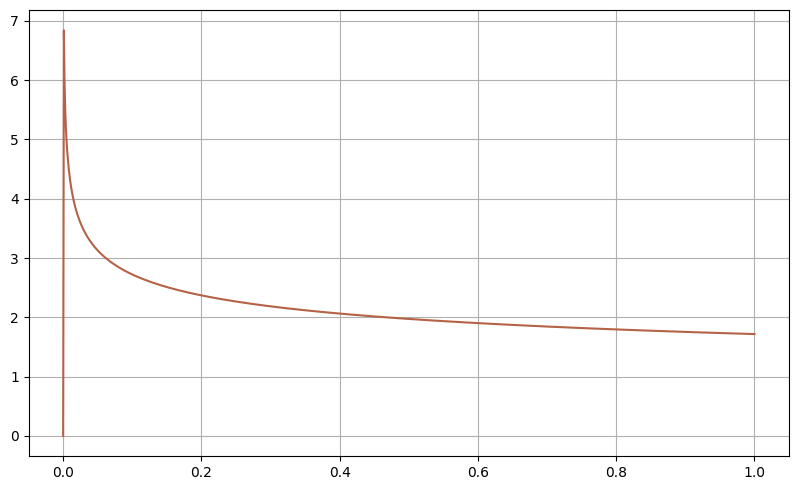

In [32]:
# mu = 3
# H = 0.3
# lam = 1
# c = 2
# alpha = 2

# T = 1
# n_steps = 1000

# rng = np.random.default_rng(seed=42)

#K = ConstantKernel(c=3)
#K = FractionalKernel(H=H, c=c)
#K = ExponentialKernel(c=c, lam=lam)
#K = GammaKernel(lam=lam, alpha=alpha, c=lam**alpha)
e = Experiment(
    T=1,
    n_steps = 1000,
    kernel = FractionalKernel(H=0.3, c=2),
    mu=3
)

plt.plot(e.t_grid, e.kernel(e.t_grid))

### Hawkes process simulation

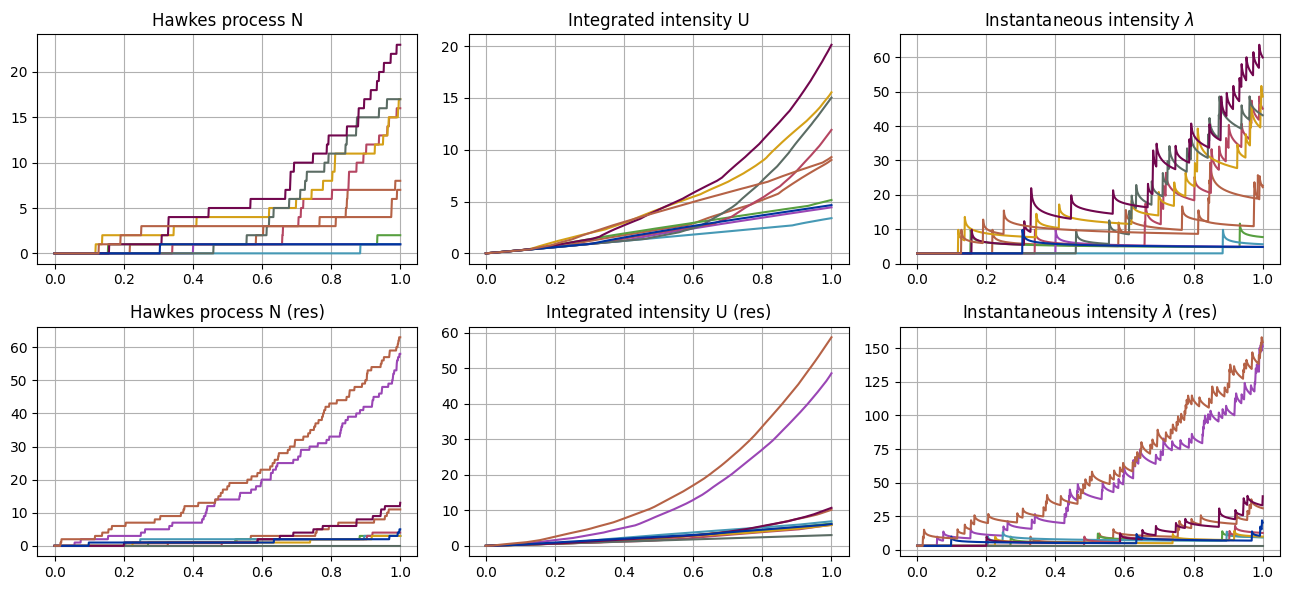

In [33]:
rng = np.random.default_rng(seed=42)
n_paths = 10

ivi_hawkes = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar, rng=rng, g0=e.g0)
ivi_hawkes_res = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar_res, g0_bar_res=e.g0_bar_res, rng=rng, g0=e.g0, resolvent_flag=True)

N, U, lam = ivi_hawkes.simulate_on_grid(t_grid=e.t_grid, n_paths=n_paths)
N_res, U_res, lam_res = ivi_hawkes.simulate_on_grid(t_grid=e.t_grid, n_paths=n_paths)


fig, ax = plt.subplots(2, 3, figsize=(13, 6))
n_show = n_paths

ax[0, 0].plot(e.t_grid, N[:, 0:n_show])
ax[0, 0].set_title('Hawkes process N')
ax[0, 0].grid("on")

ax[0, 1].plot(e.t_grid, U[:,0:n_show])
ax[0, 1].set_title('Integrated intensity U')
ax[0, 1].grid("on")

ax[0, 2].plot(e.t_grid, lam[:,0:n_show])
ax[0, 2].set_title('Instantaneous intensity $\lambda$')
ax[0, 2].grid("on")


ax[1, 0].plot(e.t_grid, N_res[:, 0:n_show])
ax[1, 0].set_title('Hawkes process N (res)')
ax[1, 0].grid("on")

ax[1, 1].plot(e.t_grid, U_res[:,0:n_show])
ax[1, 1].set_title('Integrated intensity U (res)')
ax[1, 1].grid("on")

ax[1, 2].plot(e.t_grid, lam_res[:,0:n_show])
ax[1, 2].set_title('Instantaneous intensity $\lambda$ (res)')
ax[1, 2].grid("on")

plt.show()

# Sanity check: $\mathbb{E}[N_T]$

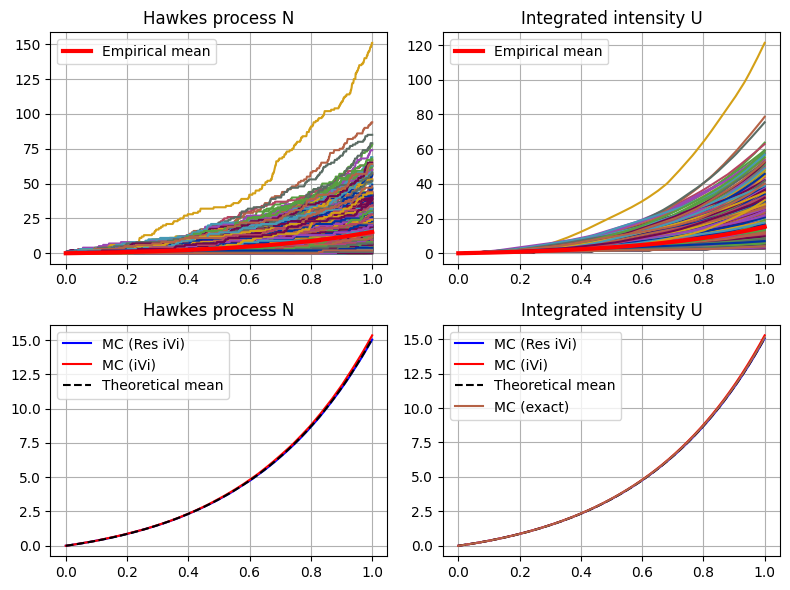

In [34]:
rng = np.random.default_rng(seed=42)
n_show = 1000
n_paths = 10000

N, U, lam = ivi_hawkes.simulate_on_grid(t_grid=e.t_grid, n_paths=n_paths)
N_res, U_res, lam_res = ivi_hawkes_res.simulate_on_grid(t_grid=e.t_grid, n_paths=n_paths)

expected_U = ivi_hawkes.U_mean(t_grid=e.t_grid)

hawkes_arrivals_sample = [simulate_hawkes(T=e.T, g0=e.g0, g0_upper_bound=e.mu, kernel=e.kernel, rng=rng) for _ in range(n_paths)]
N_T_sample = np.array([len(hawkes_arrivals) for hawkes_arrivals in hawkes_arrivals_sample])
U_sample = np.array([U_from_jumps(e.t_grid, hawkes_arrivals, e.kernel, e.g0_bar) for hawkes_arrivals in hawkes_arrivals_sample])
expected_U_mc = np.mean(U_sample, axis = 0)
                      
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0, 0].plot(e.t_grid, N[:, 0:n_show])
ax[0, 0].plot(e.t_grid, N.mean(axis=1), "r", lw=3, label="Empirical mean")
ax[0, 0].set_title('Hawkes process N')
ax[0, 0].legend()
ax[0, 0].grid("on")

ax[0, 1].plot(e.t_grid, U[:,0:n_show])
ax[0, 1].plot(e.t_grid, U.mean(axis=1), "r", lw=3, label="Empirical mean")
ax[0, 1].set_title('Integrated intensity U')
ax[0, 1].legend()
ax[0, 1].grid("on")

ax[1, 0].plot(e.t_grid, N_res.mean(axis=1), "b", label="MC (Res iVi)")
ax[1, 0].plot(e.t_grid, N.mean(axis=1), "r", label="MC (iVi)")
ax[1, 0].plot(e.t_grid, expected_U, "k--", label="Theoretical mean")
ax[1, 0].set_title('Hawkes process N')
ax[1, 0].legend()
ax[1, 0].grid("on")

ax[1, 1].plot(e.t_grid, U_res.mean(axis=1), "b", label="MC (Res iVi)")
ax[1, 1].plot(e.t_grid, U.mean(axis=1), "r", label="MC (iVi)")
ax[1, 1].plot(e.t_grid, expected_U, "k--", label="Theoretical mean")
ax[1, 1].plot(e.t_grid, expected_U_mc, label = "MC (exact)")
ax[1, 1].set_title('Integrated intensity U')
ax[1, 1].legend()
ax[1, 1].grid("on")

plt.show()

C:\Users\DM6579\AppData\Local\Temp\ipykernel_27624\3520117161.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(e.t_grid, np.abs(U_res.mean(axis = 1) - expected_U) / expected_U, label = "Res iVi")
C:\Users\DM6579\AppData\Local\Temp\ipykernel_27624\3520117161.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(e.t_grid, np.abs(U.mean(axis = 1) - expected_U) / expected_U, label = "iVi")
C:\Users\DM6579\AppData\Local\Temp\ipykernel_27624\3520117161.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(e.t_grid, np.abs(expected_U_mc - expected_U) / expected_U, label = "Exact")


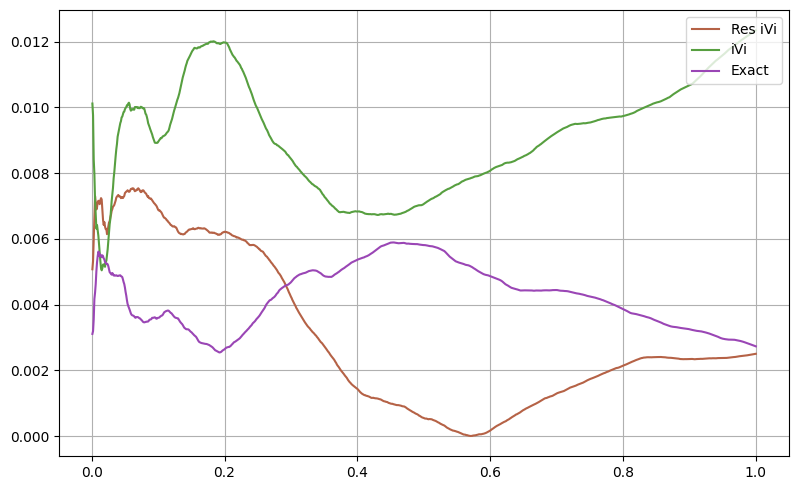

In [35]:
plt.plot(e.t_grid, np.abs(U_res.mean(axis = 1) - expected_U) / expected_U, label = "Res iVi")
plt.plot(e.t_grid, np.abs(U.mean(axis = 1) - expected_U) / expected_U, label = "iVi")
plt.plot(e.t_grid, np.abs(expected_U_mc - expected_U) / expected_U, label = "Exact")
plt.legend(loc=1)
plt.show()

# I. Marginal Laws of $N_T$ and $U_T$

In [50]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

def plot_marginal_laws(samples, flag):
    if flag == "N":
        idx = 0
    elif flag == "U":
        idx = 1
        
    fig, ax = plt.subplots(3, 2, figsize=(13, 9))

    X_T_exact = samples["Population"][idx][:, -1]
    #x_grid = np.linspace(2, 4, 1000)
    x_grid = np.linspace(0, np.max(X_T_exact), 1000)
    ecdf_exact = sm.distributions.ECDF(samples["Population"][idx][:, -1])
    ax[0, 0].plot(x_grid, ecdf_exact(x_grid), label=methods[0], linestyle = ' ', marker = '.', color="k")

    for method, ax_qq in zip(methods[1:], [ax[1,1], ax[2,0], ax[2,1]]):
        X_T = samples[method][idx][:, -1]
        ecdf = sm.distributions.ECDF(X_T)
        #x_grid = np.linspace(2, 4, 1000)
        x_grid = np.linspace(0, max(np.max(X_T), np.max(X_T_exact)), 1000)
        ax[0, 0].plot(x_grid, ecdf(x_grid), label=method)
        ax[1, 0].hist(X_T, density=True, bins=75, alpha=0.3, label=method)
        ax[0, 1].plot(x_grid, np.abs(ecdf(x_grid) - ecdf_exact(x_grid)), label=method)    
        print(method, np.max(np.abs(ecdf(x_grid) - ecdf_exact(x_grid))))
        qqplot_2samples(sm.ProbPlot(X_T_exact), sm.ProbPlot(X_T), ax=ax_qq, xlabel="Population", ylabel=method, line="45")
        if flag == "U":
            print(f"p-value Population-{method}:", ks_2samp(X_T, X_T_exact).pvalue)
            print(ks_2samp(X_T, X_T_exact))

    ax[0, 0].legend()
    ax[0, 1].legend()
    ax[1, 0].legend()

    plt.show()

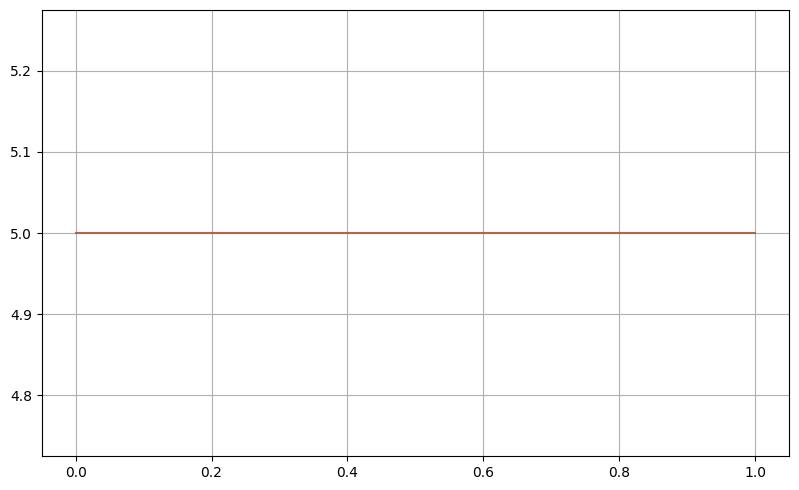

In [56]:
# H = 0.1
# c = 1
# lam = 2
# alpha = 2
# mu = 10
# T = 1

# kernel = FractionalKernel(c=c, H=H)
# kernel = ExponentialKernel(c=c, lam=lam)
#kernel = GammaKernel(lam=lam, alpha=alpha, c=lam**alpha * 0.95)
# kernel = ConstantKernel(c = 5)
rng = np.random.default_rng(seed=42)

g0_bar_res = lambda t : mu * t + mu * kernel.resolvent.double_integrated_kernel(t)

n_steps = 50

e = Experiment(
    T=1,
    n_steps = 100,
    kernel = ConstantKernel(c = 5),
    mu=3
)

plt.plot(e.t_grid, e.kernel(e.t_grid))

In [52]:
%%time

n_paths = 5000

methods = ["Population", "Ogata", "iVi", "Res iVi"]
samples = {method: get_N_U_sample(experiment=e, method=method, n_paths=n_paths) for method in methods}

CPU times: total: 13.6 s
Wall time: 14.5 s


Ogata 0.027400000000000035
iVi 0.049000000000000044
Res iVi 0.015000000000000013


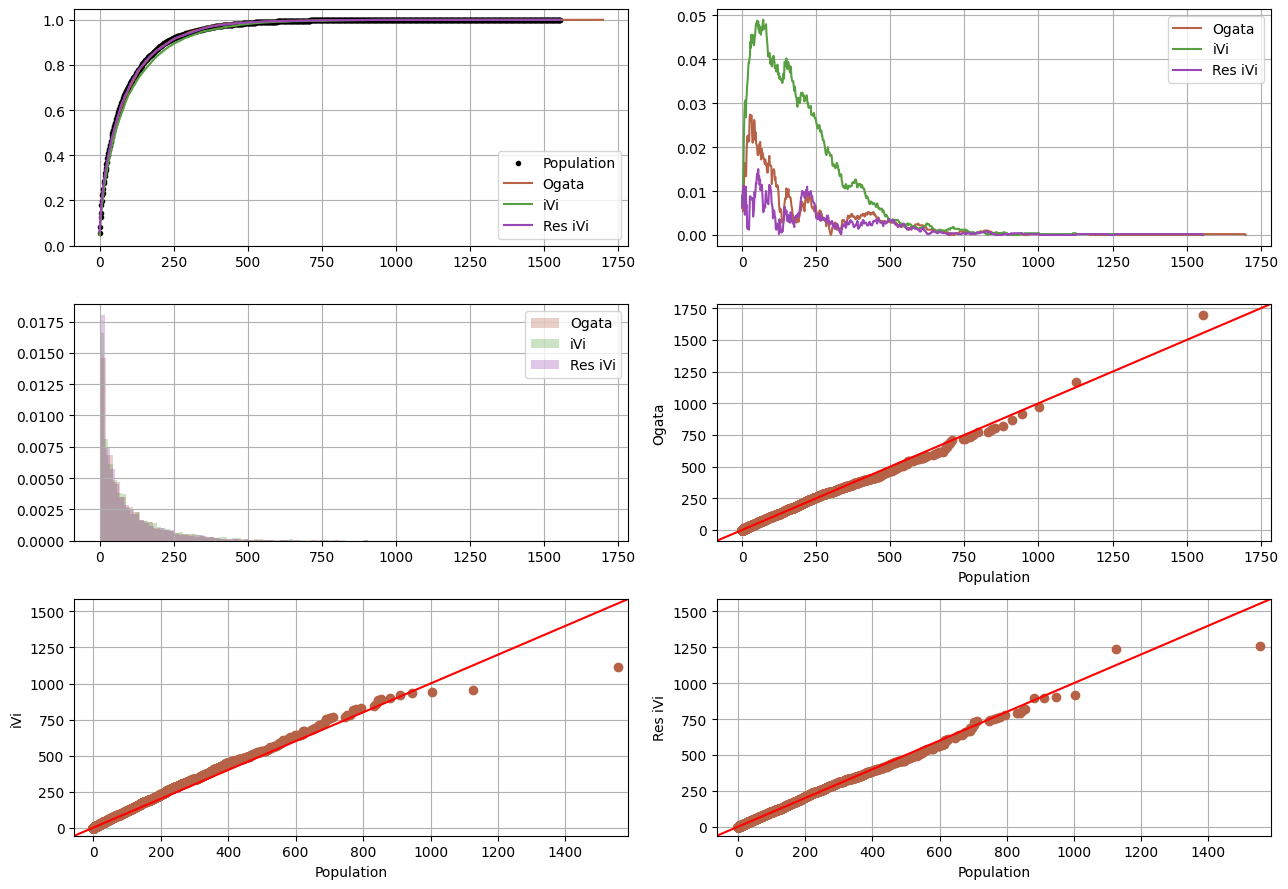

In [53]:
plot_marginal_laws(samples, "N")

In [54]:
np.min(samples["Res iVi"][1][:, -1])

2.1761305861037203

Ogata 0.030200000000000005
p-value Population-Ogata: 0.017416640543669676
KstestResult(statistic=0.0308, pvalue=0.017416640543669676, statistic_location=36.115909966316245, statistic_sign=-1)
iVi 0.0524
p-value Population-iVi: 1.953957374586669e-06
KstestResult(statistic=0.0526, pvalue=1.953957374586669e-06, statistic_location=3.0, statistic_sign=-1)
Res iVi 0.015199999999999964
p-value Population-Res iVi: 1.0360999724409651e-10
KstestResult(statistic=0.0688, pvalue=1.0360999724409651e-10, statistic_location=2.9955923399825592, statistic_sign=1)


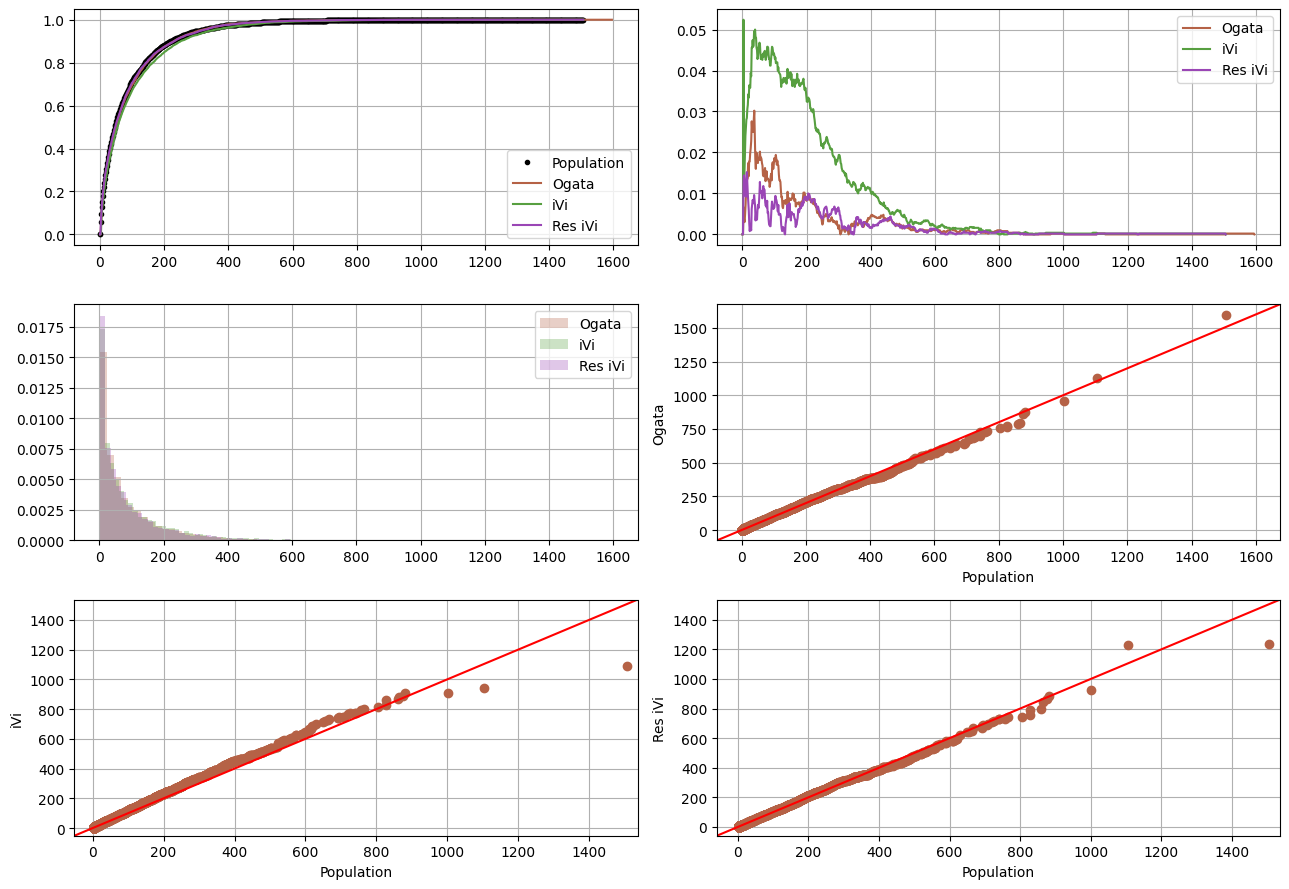

In [55]:
plot_marginal_laws(samples, "U")

# II. Distribution of arriavals

## Simulation of the jump moments

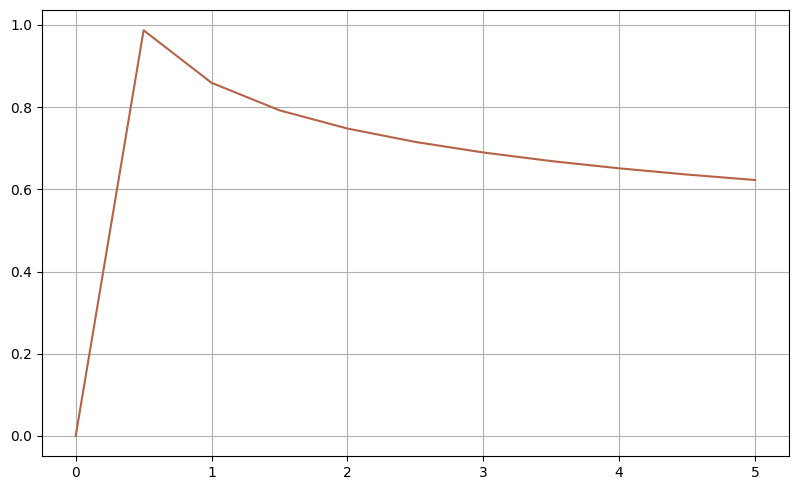

In [141]:
# H = 0.3
# lam = 1.1
# c = 1
# alpha = 2.5

# T = 10
# n_steps = 100
# n_paths = 1

# t_grid = np.linspace(0, T, n_steps + 1)

# rng = np.random.default_rng(seed = 42)


# # K = FractionalKernel(H=H, c=c)
# K = ExponentialKernel(lam=lam, c=c)
# K = GammaKernel(lam=lam, alpha=alpha, c=lam**alpha * 0.95)

# e = Experiment(
#     T=10, 
#     n_steps=1, 
#     kernel=ExponentialKernel(lam=1.1, c=1), 
#     mu=3
# )

e = Experiment(
    T=5, 
    n_steps=10, 
    kernel=FractionalKernel(H=0.3, c=1), 
    mu=3
)

plt.plot(e.t_grid, e.kernel(e.t_grid))

In [142]:
ivi_hawkes = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar, rng=np.random.default_rng(seed=43), g0=e.g0)
ivi_hawkes_res = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar, g0_bar_res=e.g0_bar_res, rng=np.random.default_rng(seed=43), g0=e.g0, resolvent_flag=True)

In [161]:
%%time
n_paths = 1
N_jumps = ivi_hawkes.simulate_arrivals(t_grid=e.t_grid, n_paths=n_paths)
N_jumps[0].shape

CPU times: total: 0 ns
Wall time: 0 ns


(8828,)

In [165]:
%%time
N_jumps_res = ivi_hawkes_res.simulate_arrivals(t_grid=e.t_grid, n_paths=n_paths)
N_jumps_res[0].shape

CPU times: total: 0 ns
Wall time: 0 ns


(906,)

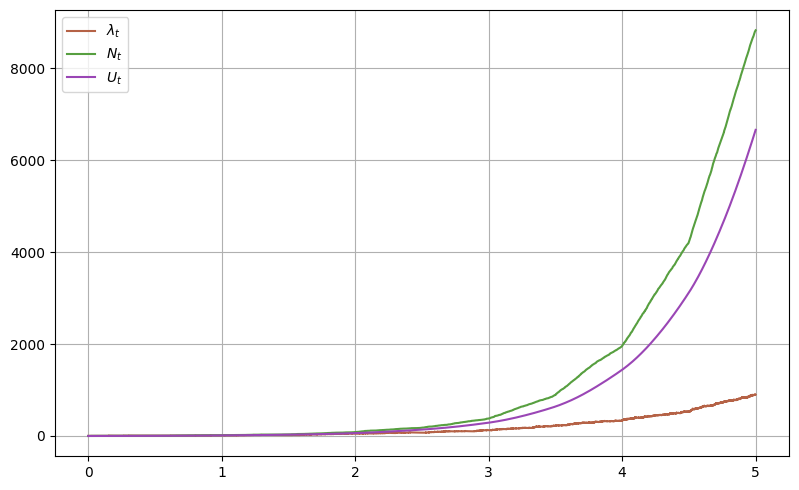

In [166]:
idx = 0

t_grid_fine = np.linspace(0, e.T, 10**4)
plt.plot(t_grid_fine, ivi_hawkes_res.lam_from_jumps(t_grid_fine, N_jumps_res[idx]), label="$\lambda_t$")
plt.plot(t_grid_fine, ivi_hawkes.N_from_jumps(t_grid_fine, N_jumps[idx]), label="$N_t$")
plt.plot(t_grid_fine, ivi_hawkes.U_from_jumps(t_grid_fine, N_jumps[idx]), label="$U_t$")
# plt.plot(t_grid_fine, ivi_hawkes.lam_from_jumps(t_grid_fine, N_jumps[idx]), label="$\lambda_t$")
plt.legend()

In [167]:
from scipy.stats import expon
import statsmodels.api as sm

def poisson_jumps_test(jumps):
    data = np.diff(jumps, prepend=0)
    data_unif = 1 - np.exp(-data)

    # Compute theoretical quantiles (from an Exponential(1) distribution)
    n = len(data)
    empirical_quantiles = np.sort(data)
    theoretical_quantiles = expon.ppf((np.arange(1, n+1) - 0.5) / n, scale=1.0)  # Inverse CDF (percent-point function)

    # Q-Q plot
    fig, ax =  plt.subplots(2, 2, figsize=(9, 8))
    ax[0, 0].scatter(theoretical_quantiles, empirical_quantiles, label="Observed vs. Exponential", s=10)
    ax[0, 0].plot(theoretical_quantiles, theoretical_quantiles, c=color_cycle[1], linestyle="dashed", label="y = x")

    ax[0, 0].set_xlabel("Theoretical Quantiles (Exponential)")
    ax[0, 0].set_ylabel("Empirical Quantiles (Data)")
    ax[0, 0].set_title("Q-Q Plot Against Exponential Distribution")
    ax[0, 0].legend()

    ax[0, 1].scatter(data_unif[:-1], data_unif[1:], s=10)
    ax[0, 1].set_title(r"$(e^{-\tau_i}, e^{-\tau_{i+1}})$")
        
    x_grid = np.linspace(data.min(), data.max(), num=1000)
    ecdf = sm.distributions.ECDF(data)
    ax[1, 0].plot(x_grid, ecdf(x_grid), label="ECDF")
    ax[1, 0].plot(x_grid, 1 - np.exp(-x_grid), "--", label="Exact CDF")
    ax[1, 0].set_title("Empirical CDF")
    ax[1, 0].legend()

    x_grid = np.linspace(0, np.max(data), 1000)
    ax[1, 1].hist(data, bins=20, density=True, alpha=0.4)
    ax[1, 1].plot(x_grid, np.exp(-x_grid), label="PDF")
    ax[1, 1].set_title("Histogram")
    ax[1, 1].legend()

    print("Kolmogorov-Smirnov test p-value: ", kstest(rvs=data, cdf=lambda x: 1 - np.exp(-x)).pvalue)
    
    plt.show()

Kolmogorov-Smirnov test p-value:  1.3503684551389351e-98


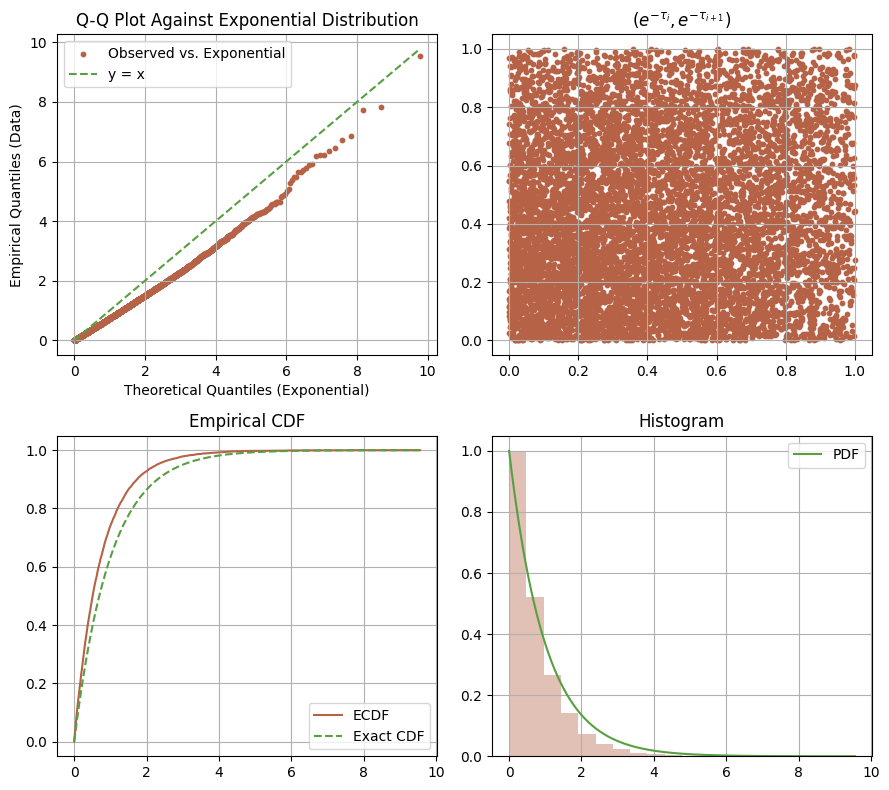

In [168]:
poisson_jumps_test(ivi_hawkes.U_from_jumps(N_jumps[idx], N_jumps[idx]))

Kolmogorov-Smirnov test p-value:  0.4066161200926206


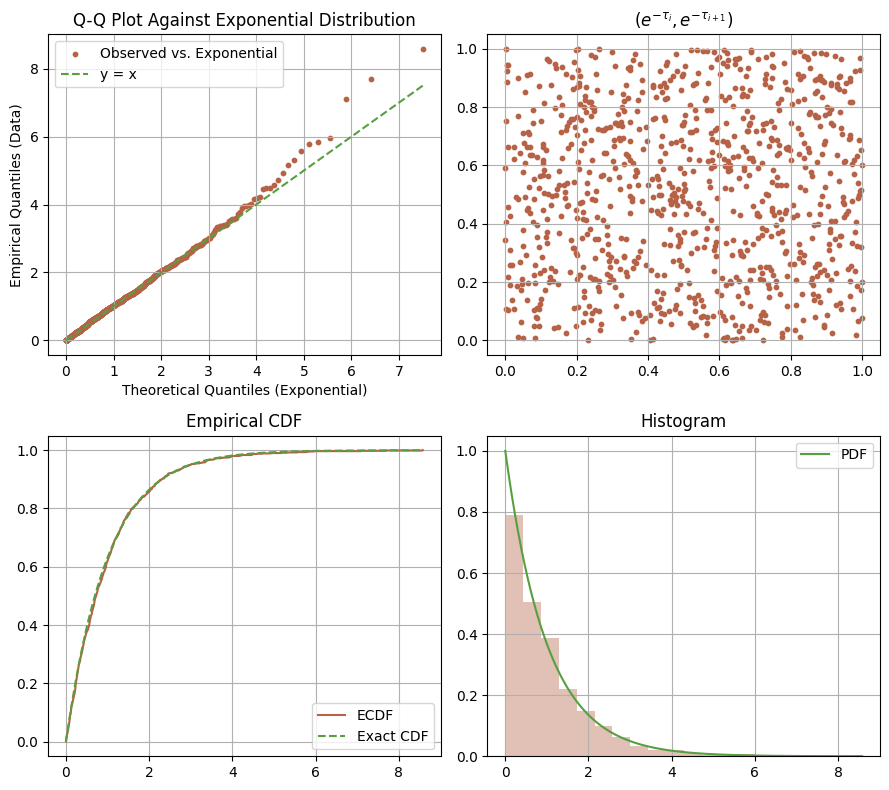

In [169]:
poisson_jumps_test(ivi_hawkes_res.U_from_jumps(N_jumps_res[idx], N_jumps_res[idx]))